<a href="https://colab.research.google.com/github/ProvenDruid/regularization/blob/main/Regularization_batchingV1_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Regularization using mini batches**

In [ ]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [ ]:
import pandas as pd
iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')

# organize the data

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

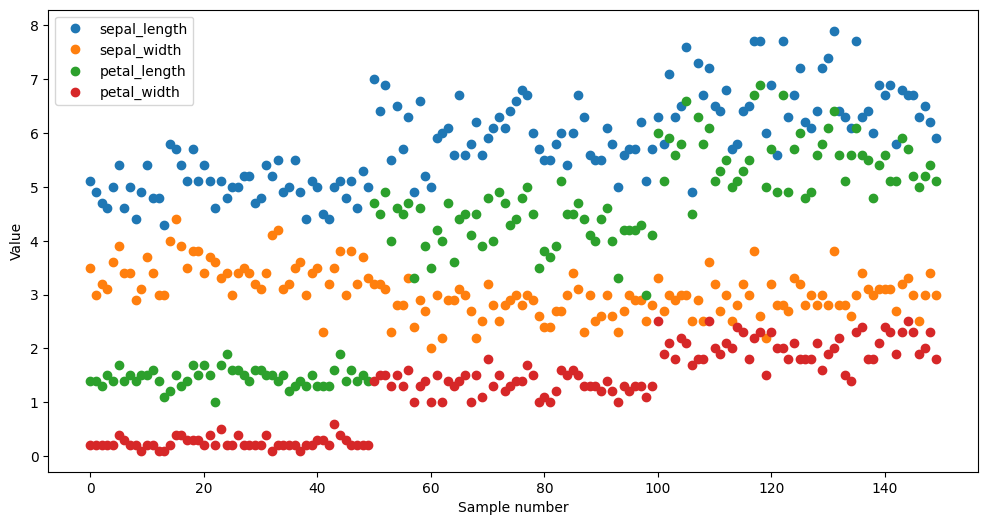

In [ ]:
# plot the data
iris.plot(marker='o',linestyle='none',figsize=(12,6))
plt.xlabel('Sample number')
plt.ylabel('Value')
plt.show()

In [ ]:
####   ------------------------------- < NOTE ABOUT THIS CELL!!! > ---------------------------------------   ####
#                                                                                                               #
# The code here is intentionally commented out. We're going to use this in the lecture "The importance of       #
# data standardization" in the next section. If you're not doing that lecture, leave this commented! Thanks!    #
#                                                                                                               #
####   ------------------------------- </ NOTE ABOUT THIS CELL!!! > --------------------------------------   ####


# # z-score the data
# import scipy.stats as stats
# cols2zscore = iris.keys()
# cols2zscore = cols2zscore.drop('species')
# iris[cols2zscore] = iris[cols2zscore].apply(stats.zscore)

# iris.plot(marker='o',linestyle='none',figsize=(12,6))
# plt.xlabel('Sample number')
# plt.ylabel('Value')
# plt.show()

# **Making the batches**

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_dataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataset,batch_size=test_dataset.tensors[0].shape[0]) # how big should these batches be??

In [ ]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,y.shape)

# go back and set drop_last=True in training DataLoader

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 2500

def trainTheModel():

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []
  losses   = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )
    losses.append( np.mean(batchLoss) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc,losses

In [ ]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc,losses = trainTheModel()

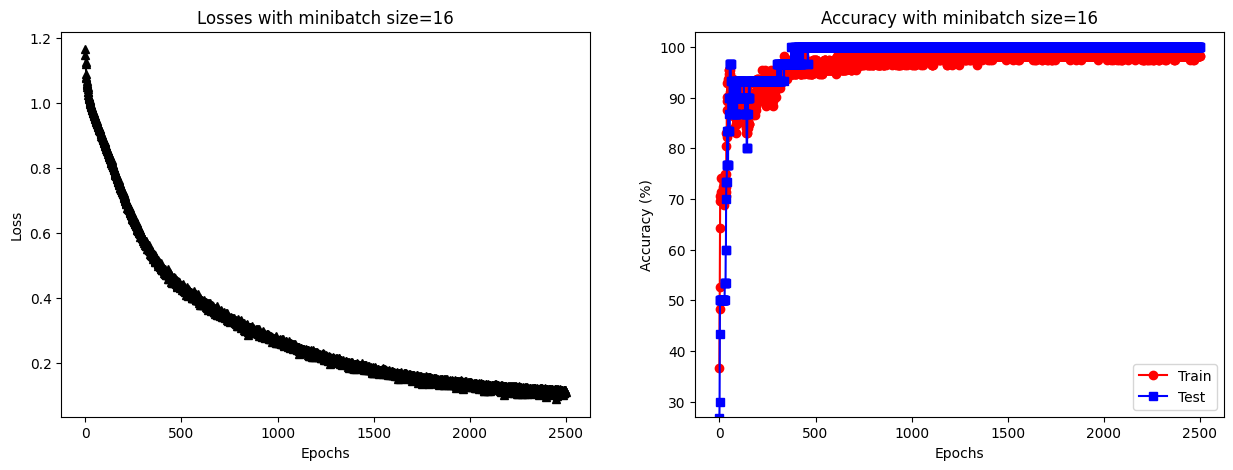

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with minibatch size=' + str(batchsize))

ax[1].plot(trainAcc,'ro-')
ax[1].plot(testAcc,'bs-')
ax[1].set_title('Accuracy with minibatch size=' + str(batchsize))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([27,103])

plt.show()

# Experiment, set batchsize to 2**N for N=1,2,3,4,5,6 and lr to 0.001, store resulting train and test acc over epochs for each batch **size**

In [ ]:
def splitIntoBatches(bs):
  # use scikitlearn to split the data
  train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.2)


  # then convert them into PyTorch Datasets (note: already converted to tensors)
  train_data = TensorDataset(train_data,train_labels)
  test_data  = TensorDataset(test_data,test_labels)


  # finally, translate into dataloader objects
  batchsize    = 2**bs
  train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
  test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
  return train_loader, test_loader

In [ ]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.0005)

  return ANNiris,lossfun,optimizer

In [ ]:
# train the model

# global parameter
numepochs = 500

def trainTheModelExp(train_loader, test_loader):

  # initialize accuracies as empties
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
      batchLoss.append( loss.item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc


# **Now the experiment**

In [ ]:
trainAccM=np.zeros((500,6))
testAccM=np.zeros((500,6))

batchSizes=[1,2,3,4,5,6]

for bs in batchSizes:
  train_loader,test_loader=splitIntoBatches(bs)
  ANNiris,lossfun,optimizer=createANewModel()
  trainAcc,testAcc=trainTheModelExp(train_loader,test_loader)
  trainAccM[:,bs-1]=trainAcc
  testAccM[:,bs-1]=testAcc





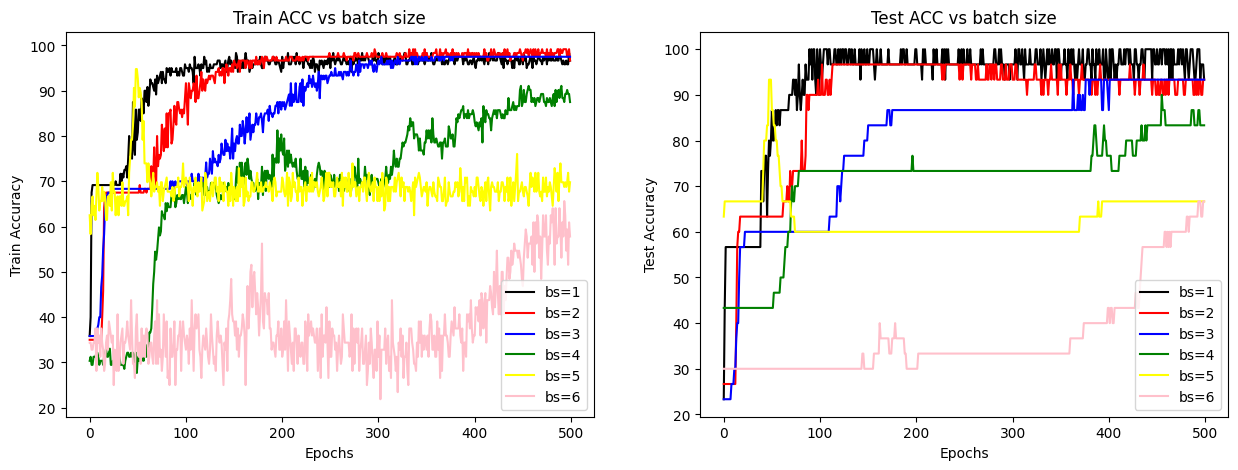

In [ ]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(trainAccM[:,0], color='black', linestyle='-', label='bs=1')
ax[0].plot(trainAccM[:,1], color='red', linestyle='-', label='bs=2')
ax[0].plot(trainAccM[:,2], color='blue', linestyle='-', label='bs=3')
ax[0].plot(trainAccM[:,3], color='green', linestyle='-', label='bs=4')
ax[0].plot(trainAccM[:,4], color='yellow', linestyle='-', label='bs=5')
ax[0].plot(trainAccM[:,5], color='pink', linestyle='-', label='bs=6')
ax[0].set_ylabel('Train Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Train ACC vs batch size')
#ax[0].legend(['bs=1'])
ax[0].legend()


ax[1].plot(testAccM[:,0], color='black', linestyle='-', label='bs=1')
ax[1].plot(testAccM[:,1], color='red', linestyle='-', label='bs=2')
ax[1].plot(testAccM[:,2], color='blue', linestyle='-', label='bs=3')
ax[1].plot(testAccM[:,3], color='green', linestyle='-', label='bs=4')
ax[1].plot(testAccM[:,4], color='yellow', linestyle='-', label='bs=5')
ax[1].plot(testAccM[:,5], color='pink', linestyle='-', label='bs=6')
ax[1].set_ylabel('Test Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Test ACC vs batch size')
#ax[0].legend(['bs=1'])
ax[1].legend()

plt.show()